In [1]:
import os
from typing import Optional
from datetime import datetime

import numpy as np
import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from shapely.geometry import Point, Polygon
import xyzservices.providers as xyz
import contextily as ctx

In [2]:
DEFAULT_CMAP = "Greens"

DEFAULT_BIKESHARE_FILE = "processed_data/bikeshare_2025-02-28_15-44-09.geojson"
SEATTLE_GEOJSON_URL = "https://raw.githubusercontent.com/seattleflu/seattle-geojson/master/seattle_geojsons/2016_seattle_city.geojson"
NEIGHBORHOOD_BOUNDARIES_URL = "https://raw.githubusercontent.com/seattleio/seattle-boundaries-data/refs/heads/master/data/neighborhoods.geojson"

In [3]:
bikeshare_gdf = gpd.read_file(os.path.join("../../", DEFAULT_BIKESHARE_FILE), engine='pyogrio')

In [4]:
seattle_road_filepath = os.path.join("../../", "processed_data/seattle_road_edges.geojson")
seattle_road_gdf = gpd.read_file(seattle_road_filepath, engine='pyogrio')

SEATTLE_ROADS_GDF = seattle_road_gdf.to_crs(bikeshare_gdf.crs)

Skipping field highway: unsupported OGR type: 5
Skipping field lanes: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5
Skipping field bridge: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field tunnel: unsupported OGR type: 5
Skipping field access: unsupported OGR type: 5
Skipping field service: unsupported OGR type: 5
Skipping field width: unsupported OGR type: 5


In [17]:
collisions_gdf = gpd.read_file(os.path.join("../../", "processed_data/seattle_collisions.geojson"), engine='pyogrio')
SEATTLE_COLLISIONS_GDF = collisions_gdf[(collisions_gdf['PEDCOUNT'] > 0)|(collisions_gdf['PEDCYLCOUNT'] > 0)]
SEATTLE_COLLISIONS_GDF

,STATUS,ADDRTYPE,INTKEY,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,...,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,SPDCASENO,SOURCEDESC,ADDDTTM,MODDTTM,SHAREDMICROMOBILITYDESC,YEAR,geometry
4,Matched,Intersection,30603.0,28TH AVE S AND S JACKSON ST,1,Property Damage Only Collision,Cycles,2,0,1,...,0,0,N,23-194663,Police Traffic Collision Report,2023-07-17,2024-04-16,None,2023,POINT (552903.15 5271996.569)
20,Matched,Intersection,29581.0,2ND AVE AND STEWART ST,2b,Serious Injury Collision,Pedestrian,2,1,0,...,0,0,N,2024-268282,Police Traffic Collision Report,2024-09-23,2025-02-12,Unknown,2024,POINT (549567.957 5273272.674)
26,Matched,Intersection,23926.0,15TH AVE NW AND NW 70TH ST,2,Injury Collision,Pedestrian,2,1,0,...,0,0,N,2024-112306,Police Traffic Collision Report,2024-09-19,2024-09-19,Unknown,2024,POINT (546777.287 5280870.276)
45,Matched,Intersection,35271.0,M L KING JR WR WAY S AND S HENDERSON ST,1,Property Damage Only Collision,Pedestrian,2,1,0,...,0,0,N,2023-50361,Police Traffic Collision Report,2023-07-14,2023-07-18,None,2023,POINT (554261.142 5263564.961)
57,Matched,Intersection,33624.0,32ND AVE S AND S ORCAS ST,2,Injury Collision,Cycles,2,0,1,...,0,0,N,2024-250994,Police Traffic Collision Report,2024-09-19,2024-11-12,Unknown,2024,POINT (553303.606 5266635.82)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36230,Matched,Block,NaN,32ND AVE SW BETWEEN SW MORGAN ST AND SW HOLLY ST,2,Injury Collision,Pedestrian,2,1,0,...,0,0,N,23-83201,Police Traffic Collision Report,2023-04-12,2023-08-04,None,2023,POINT (547123.794 5265783.044)
36237,Matched,Block,NaN,MINOR AVE BETWEEN UNION ST AND PIKE ST,2,Injury Collision,Pedestrian,2,1,0,...,0,0,N,2022-348314,Police Traffic Collision Report,2023-05-09,2023-05-09,None,2022,POINT (550549.621 5273555.883)
36242,Matched,Intersection,25804.0,UNIVERSITY WAY NE AND NE 47TH ST,2,Injury Collision,Pedestrian,2,1,0,...,0,0,N,2023-127518,Police Traffic Collision Report,2023-05-26,2023-10-30,None,2023,POINT (551572.13 5279083.901)
36251,Matched,Block,NaN,30TH AVE NE BETWEEN NE 107TH ST AND NE 110TH ST,2,Injury Collision,Pedestrian,2,1,0,...,0,0,N,23-36359,Police Traffic Collision Report,2023-06-14,2023-07-05,None,2023,POINT (552794.165 5284035.567)


In [18]:
def load_seattle_boundary(url: str) -> gpd.GeoDataFrame:
    """
    Load seattle boundary as a geopandas dataframe.

    :param url: URL to Seattle boundary GeoJSON file

    :return: GeoDataFrame of Seattle boundary
    """
    seattle_gdf = gpd.read_file(url, engine='pyogrio')
    seattle_gdf.to_crs("EPSG:32610", inplace=True)

    return seattle_gdf


def load_neighborhoods(
    url: str,
    seattle_gdf: gpd.GeoDataFrame
) -> gpd.GeoDataFrame:
    """
    Load Seattle neighborhoods geopandas dataframe.

    :param url: URL to Seattle neighborhoods GeoJSON file
    :param seattle_gdf: GeoDataFrame of Seattle boundary

    :return: GeoDataFrame of Seattle neighborhoods
    """
    seattle_neighborhoods_gdf = gpd.read_file(url, engine='pyogrio')
    seattle_neighborhoods_gdf.to_crs("EPSG:32610", inplace=True)

    seattle_neighborhoods_gdf = seattle_neighborhoods_gdf.clip(seattle_gdf)
    
    return seattle_neighborhoods_gdf


def dissolve_neighborhoods(
    seattle_neighborhoods_gdf: gpd.GeoDataFrame
) -> gpd.GeoDataFrame:
    """
    Group nested neighborhoods into single nieghborhood polygons

    :param seattle_neighborhoods_gdf: GeoDataFrame of Seattle neighborhoods

    :return: Dissolved GeoDataFrame of Seattle neighborhoods
    """
    return seattle_neighborhoods_gdf[["nhood", "area", "geometry"]].dissolve(by="nhood", aggfunc="sum")


def filter_bikeshare_system_by_nhood(
    bikeshare_gdf: gpd.GeoDataFrame,
    nhood_gdf: gpd.GeoDataFrame,
    neighborhood: Optional[str] = None
) -> tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Filter bikeshare system by neighborhood

    :param bikeshare_gdf: GeoDataFrame of bikeshare system data
    :param nhood_gdf: GeoDataFrame of Seattle neighborhoods
    :param neighborhood: Name of neighborhood to focus on

    :return: Tuple of filtered bikeshare GeoDataFrame and neighborhood GeoDataFrame
    """
    if neighborhood:
        if neighborhood not in nhood_gdf.index:
            raise ValueError(f"Neighborhood '{neighborhood}' not found in Seattle. Must be one of {nhood_gdf.index}.")
        else:
            nhood_sub_gdf = nhood_gdf[nhood_gdf.index == neighborhood]
    else:
        nhood_sub_gdf = nhood_gdf

    return bikeshare_gdf.clip(nhood_sub_gdf), nhood_sub_gdf


def filter_bikeshare_system_by_start_date(
    gdf: gpd.GeoDataFrame,
    start_date: datetime,
    num_days: int
) -> gpd.GeoDataFrame:
    """
    Filter bikshare system by date
    
    :param gdf: GeoDataFrame of bikeshare system data
    :param start_date: Start date for filtering
    :param num_days: Number of days to filter
    
    :return: Filtered GeoDataFrame
    """
    end_time = start_date + pd.Timedelta(days=num_days)
    mask = (gdf.datetime >= start_date) & (gdf.datetime < end_time)

    return gdf.loc[mask]

In [26]:
def add_coords_as_column(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Add x and y coordinates as columns to GeoDataFrame

    :param gdf: GeoDataFrame to add coordinates to

    :return: GeoDataFrame with x and y coordinates
    """
    sub_coords = gdf.geometry.get_coordinates()

    with_coords_gdf = gdf.merge(
        sub_coords,
        left_index=True,
        right_index=True,
        how='inner',
    )
    return with_coords_gdf


def plot_hexbins(
    bikeshare_gdf: gpd.GeoDataFrame,
    nhood_sub_gdf: gpd.GeoDataFrame,
    neighborhood: str,
    date: str,
    save: bool = False,
    roads_gdf: gpd.GeoDataFrame = SEATTLE_ROADS_GDF,
    cmap: str = DEFAULT_CMAP,
) -> None:
    """
    Plot a hexbin based heatmap of scooter and bike distribution in Seattle

    :param bikeshare_gdf: GeoDataFrame of bikeshare system data
    :param nhood_sub_gdf: GeoDataFrame of Seattle neighborhoods
    :param neighborhood: Name of neighborhood to focus on
    :param date: Date to plot data for
    :param save: Whether to save the plot to a file
    :param roads_gdf: GeoDataFrame of Seattle road edges
    
    :return: None
    """
    scooters = bikeshare_gdf[bikeshare_gdf.vehicle_type == "scooter"]
    bikes = bikeshare_gdf[bikeshare_gdf.vehicle_type == "e-bike"]

    if neighborhood:
        gridsize = (30, 14)
    else:
        gridsize = (50, 28)

    fig, axs = plt.subplots(2, 2, figsize=(8, 9), sharex=True, sharey=True)

    for ax in axs.flat:
        nhood_sub_gdf.plot(ax=ax,  facecolor="None", edgecolor='black')
        ax.axis("off")

    vmax = 600

    alpha = .5

    scooters.plot.hexbin(
        "x",
        "y",
        ax=axs[0, 0],
        norm=colors.LogNorm(),
        gridsize=gridsize,
        alpha=alpha,
        cmap=cmap,
        mincnt=1,
        title="Scooters (Log Scale)",
        legend=False,
    )

    bikes.plot.hexbin(
        "x",
        "y",
        ax=axs[0, 1],
        norm=colors.LogNorm(),
        gridsize=gridsize,
        alpha=alpha,
        cmap=cmap,
        mincnt=1,
        title="E-Bikes (Log Scale)"
    )

    scooters.plot.hexbin(
        "x",
        "y",
        ax=axs[1, 0],
        gridsize=gridsize,
        alpha=alpha,
        cmap=cmap,
        mincnt=1,
        vmin=0,
        vmax=vmax,
        title="Scooters (Normal Scale)"
    )
    bikes.plot.hexbin(
        "x",
        "y",
        ax=axs[1, 1],
        gridsize=gridsize,
        alpha=alpha,
        cmap=cmap,
        vmin=0,
        vmax=vmax,
        mincnt=1,
        title="E-Bikes (Normal Scale)",
        legend=False
    )

    plt.tight_layout()
    plt.suptitle(f"Scooter and Bike Distribution in Seattle on {date}{f':\n{neighborhood}' if neighborhood else ''}", fontsize=16)
    plt.subplots_adjust(top=0.9)

    if neighborhood:
        for ax in axs.flat:
            roads_gdf.clip(nhood_sub_gdf).plot(linewidth=0.25, color='k', ax=ax, zorder=0)
            # ctx.add_basemap(ax, crs=bikeshare_gdf.crs, source=ctx.providers.CartoDB.VoyagerNoLabels, attribution=False)
            ctx.add_basemap(ax, crs=bikeshare_gdf.crs, source=ctx.providers.CartoDB.Positron, attribution=False, zorder=-1)

    if save:
        plt.savefig(f"../../visuals/scooter_bike_hexbin_in_{neighborhood}_{date.replace('-', '_')}_{cmap}.png")
    else:
        plt.show()


def plot_kde(
    gdf: gpd.GeoDataFrame,
    nhood_sub_gdf: gpd.GeoDataFrame,
    neighborhood: str,
    date: str,
    save: bool = False,
    roads_gdf: gpd.GeoDataFrame = SEATTLE_ROADS_GDF,
    cmap: str = DEFAULT_CMAP,
) -> None:
    """
    Plot a KDE based heatmap of scooter and bike distribution in Seattle

    :param gdf: GeoDataFrame of bikeshare system data
    :param nhood_sub_gdf: GeoDataFrame of Seattle neighborhoods
    :param neighborhood: Name of neighborhood to focus on
    :param date: Date to plot data for
    :param save: Whether to save the plot to a file
    :param roads_gdf: GeoDataFrame of Seattle road edges

    :return: None
    """
    # STUDENT CODE HERE
    fig = plt.figure(figsize=(6,8), dpi=100)
    ax = fig.add_subplot(111)

    sns.kdeplot(
        data=gdf,
        x=gdf['x'],
        y=gdf['y'],
        ax=ax,
        cmap=cmap,
        fill=True,
        # cbar=True,
        alpha=0.5
    )
    nhood_sub_gdf.plot(ax=ax, edgecolor='grey', facecolor="None")
    if neighborhood:
        roads_gdf.clip(nhood_sub_gdf).plot(linewidth=0.25, color='k', ax=ax, zorder=0)
    ctx.add_basemap(ax, crs=bikeshare_gdf.crs, source=ctx.providers.CartoDB.Positron, attribution=False, zorder=-1)
    SEATTLE_COLLISIONS_GDF.clip(nhood_sub_gdf).plot(ax=ax, color='red', markersize=3, alpha=0.3, zorder=2, label='micromobility collisions')
    ax.axis("off")
    ax.set_title(f"Seattle Lime Bikeshare System Density on {date}{f':\n{neighborhood}' if neighborhood else ''}")
    plt.subplots_adjust(top=0.9)
    plt.tight_layout()
    plt.legend()

    if save:
        plt.savefig(f"../../visuals/lime_bike_in_{neighborhood}_density_all_day_{date.replace("-", "_")}_{cmap}_with_collisions.png")
    else:
        plt.show()


def plot_bikeshare_heatmaps(
    bikeshare_gdf: gpd.GeoDataFrame,
    date: str,
    num_days: int,
    neighborhood: Optional[str] = None,
    save: bool = True,
    cmap=DEFAULT_CMAP,
) -> None:
    seattle_gdf = load_seattle_boundary(url=SEATTLE_GEOJSON_URL)
    seattle_neighborhoods_gdf = load_neighborhoods(url=NEIGHBORHOOD_BOUNDARIES_URL, seattle_gdf=seattle_gdf)
    seattle_neighborhoods_dissolved_gdf = dissolve_neighborhoods(seattle_neighborhoods_gdf)
    bikeshare_sub_gdf = filter_bikeshare_system_by_start_date(
        gdf=bikeshare_gdf, start_date=datetime.strptime(date, "%Y-%m-%d"), num_days=num_days
    )
    bikeshare_sub_gdf, nhood_sub_gdf = filter_bikeshare_system_by_nhood(
        bikeshare_gdf=bikeshare_sub_gdf,
        nhood_gdf=seattle_neighborhoods_dissolved_gdf,
        neighborhood=neighborhood,
    )

    bikeshare_sub_with_coords_gdf = add_coords_as_column(bikeshare_sub_gdf)

    plot_hexbins(
        bikeshare_sub_with_coords_gdf,
        nhood_sub_gdf,
        neighborhood,
        date,
        save=save,
        cmap=cmap,
    )
    plot_kde(
        bikeshare_sub_with_coords_gdf,
        nhood_sub_gdf,
        neighborhood,
        date,
        save=save,
        cmap=cmap,
    )

In [27]:
date = '2025-02-22'
num_days = 1
neighborhood = None

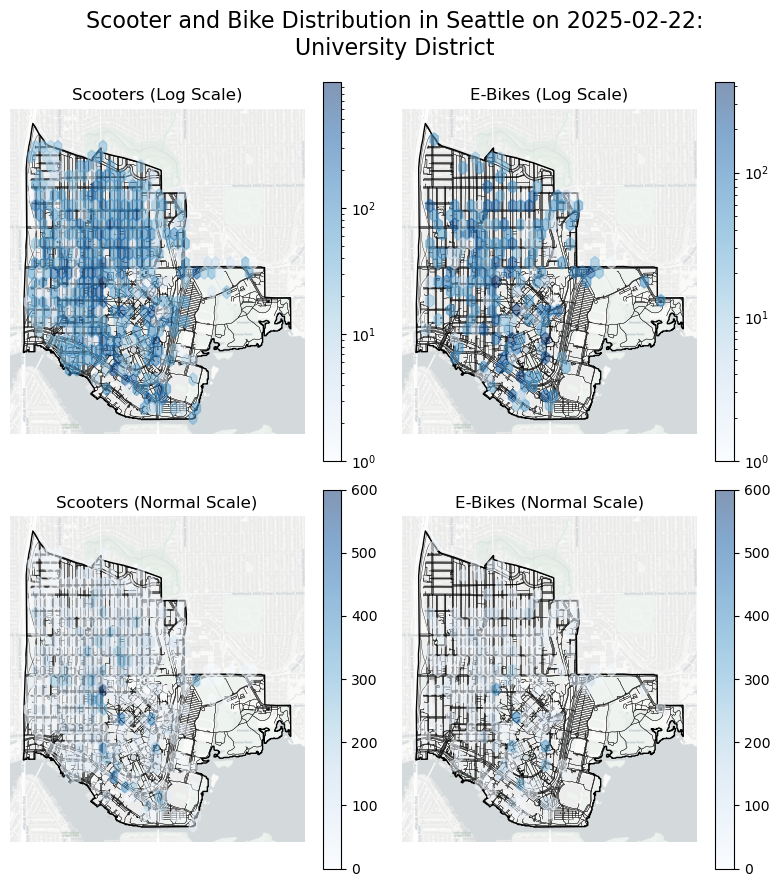

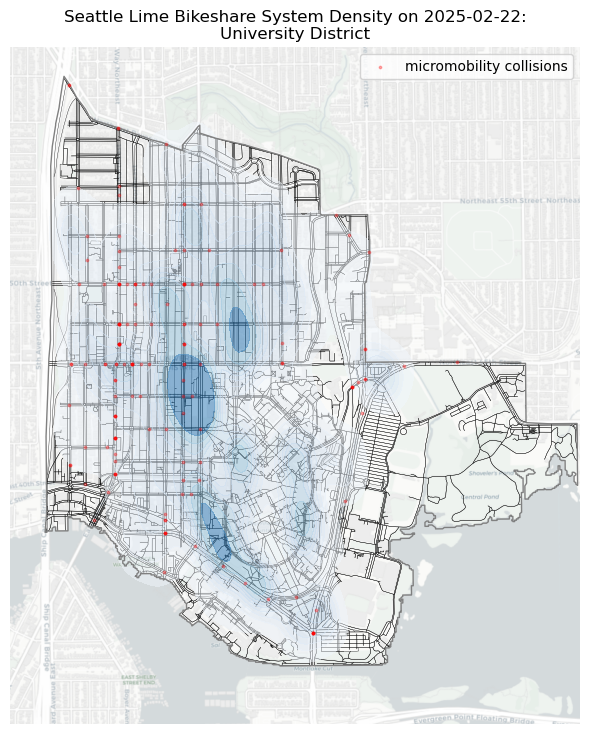

In [28]:
plot_bikeshare_heatmaps(bikeshare_gdf, date, num_days, "University District", save=True, cmap="Blues")

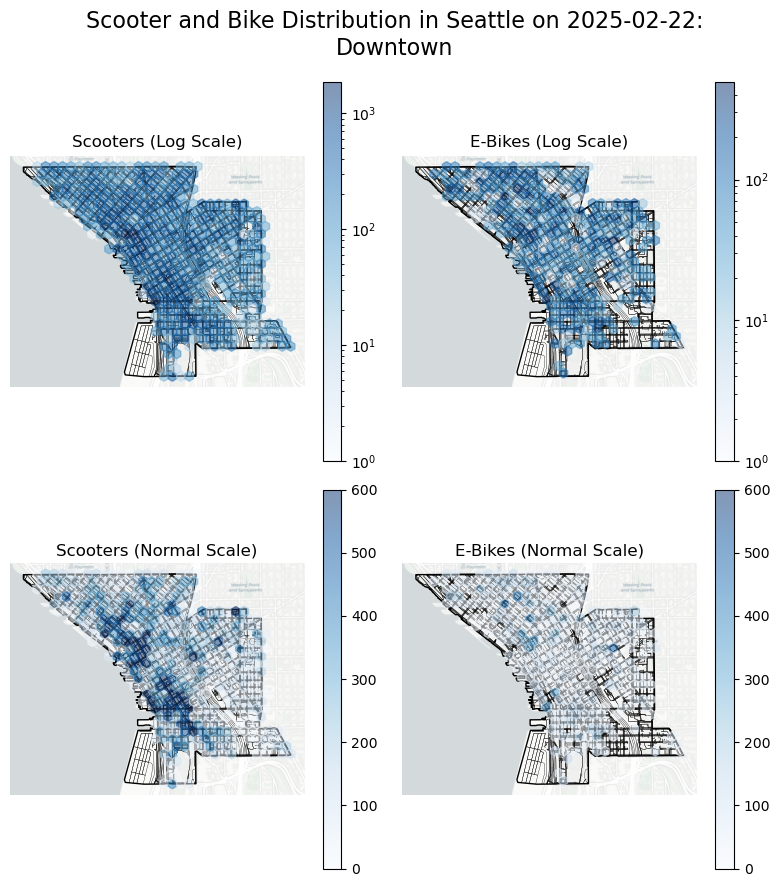

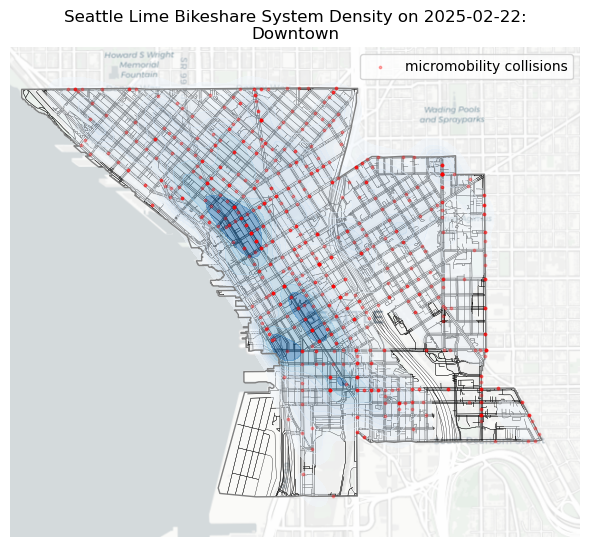

In [29]:
plot_bikeshare_heatmaps(bikeshare_gdf, date, num_days, "Downtown", save=True, cmap="Blues")

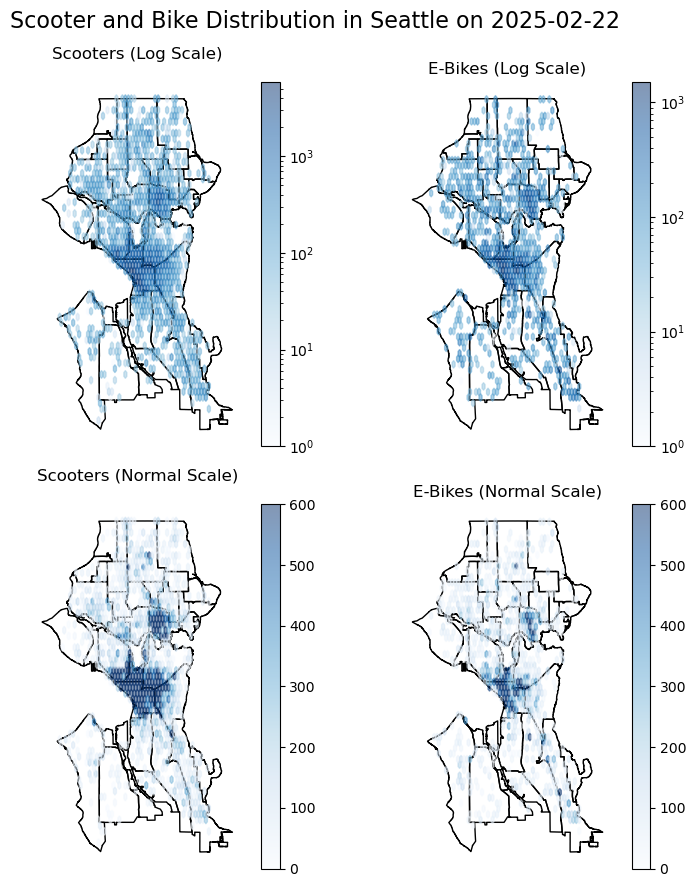

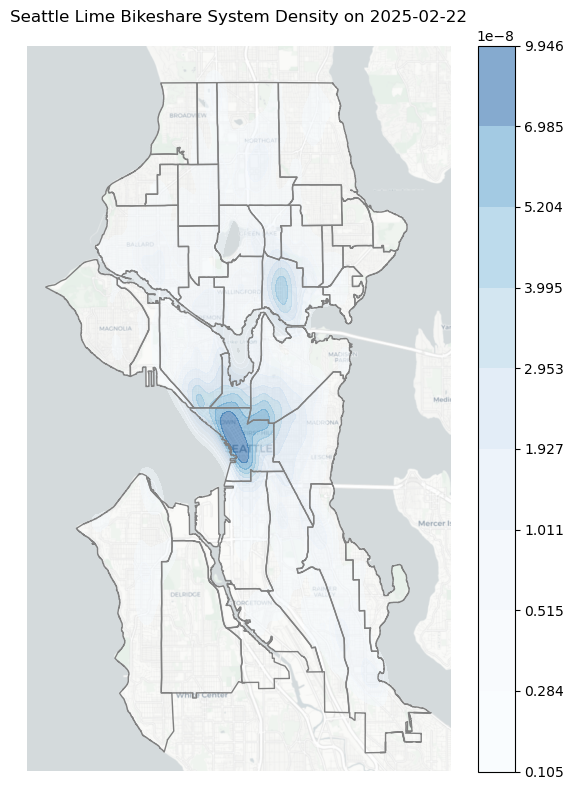

In [9]:
plot_bikeshare_heatmaps(bikeshare_gdf, date, num_days, neighborhood=neighborhood, save=True, cmap="Blues")

In [ ]:
# alpha = 0.5
# DEFAULT_CMAP = "Greens"

# seattle_gdf = load_seattle_boundary(url=SEATTLE_GEOJSON_URL)
# seattle_neighborhoods_gdf = load_neighborhoods(url=NEIGHBORHOOD_BOUNDARIES_URL, seattle_gdf=seattle_gdf)
# seattle_neighborhoods_dissolved_gdf = dissolve_neighborhoods(seattle_neighborhoods_gdf)
# bikeshare_sub_gdf = filter_bikeshare_system_by_start_date(
#     gdf=bikeshare_gdf, start_date=datetime.strptime(date, "%Y-%m-%d"), num_days=num_days
# )
# bikeshare_sub_gdf, nhood_sub_gdf = filter_bikeshare_system_by_nhood(
#     bikeshare_gdf=bikeshare_sub_gdf,
#     nhood_gdf=seattle_neighborhoods_dissolved_gdf,
#     neighborhood=neighborhood,
# )
# bikeshare_sub_coords = bikeshare_sub_gdf.geometry.get_coordinates()

# bikeshare_sub_with_coords_gdf = bikeshare_sub_gdf.merge(
#     bikeshare_sub_coords,
#     left_index=True,
#     right_index=True,
#     how='inner',
# )

# scooters = bikeshare_sub_with_coords_gdf[bikeshare_sub_with_coords_gdf.vehicle_type == "scooter"]
# bikes = bikeshare_sub_with_coords_gdf[bikeshare_sub_with_coords_gdf.vehicle_type == "e-bike"]

# fig, axs = plt.subplots(2, 2, figsize=(8, 9), sharex=True, sharey=True, dpi=100)

# for ax in axs.flat:
#     nhood_sub_gdf.plot(ax=ax,  facecolor="None", edgecolor='black')
#     ax.axis("off")

# scooters.plot.hexbin(
#     "x",
#     "y",
#     ax=axs[0, 0],
#     norm=colors.LogNorm(),
#     gridsize=(50,28),
#     alpha=alpha,
#     cmap=DEFAULT_CMAP,
#     mincnt=1,
#     title="Scooters (Log Scale)",
#     legend=False,
# )

# bikes.plot.hexbin(
#     "x",
#     "y",
#     ax=axs[0, 1],
#     norm=colors.LogNorm(),
#     gridsize=(50,28),
#     alpha=alpha,
#     cmap=DEFAULT_CMAP,
#     mincnt=1,
#     title="E-Bikes (Log Scale)"
# )

# scooters.plot.hexbin(
#     "x",
#     "y",
#     ax=axs[1, 0],
#     gridsize=(50,28),
#     alpha=alpha,
#     cmap=DEFAULT_CMAP,
#     mincnt=1,
#     title="Scooters (Normal Scale)"
# )
# bikes.plot.hexbin(
#     "x",
#     "y",
#     ax=axs[1, 1],
#     gridsize=(50,28),
#     alpha=alpha,
#     cmap=DEFAULT_CMAP,
#     mincnt=1,
#     title="E-Bikes (Normal Scale)"
# )
# seattle_road_gdf.clip(nhood_sub_gdf).plot(linewidth=0.1, color='k', ax=axs[1,1], zorder=0)
# plt.tight_layout()
# plt.suptitle(f"Scooter and Bike Distribution in Seattle on {date}", fontsize=16)
# plt.subplots_adjust(top=0.9)
# # plt.savefig(f"../visuals/scooter_bike_hexbin_{date.replace('-', '_')}.png")
# plt.show()

# # STUDENT CODE HERE
# fig = plt.figure(figsize=(6,8), dpi=100)
# ax = fig.add_subplot(111)

# sns.kdeplot(
#     data=bikeshare_sub_with_coords_gdf,
#     x=bikeshare_sub_with_coords_gdf['x'],
#     y=bikeshare_sub_with_coords_gdf['y'],
#     ax=ax,
#     cmap=DEFAULT_CMAP,
#     fill=True,
#     cbar=True,
# )
# nhood_sub_gdf.plot(ax=ax, edgecolor='grey', facecolor="None")
# ax.axis("off")
# # ax.set_xlim(xlim_left, xlim_right)
# # ax.set_ylim(ylim_bottom, ylim_top)
# ax.set_title(f"Seattle Lime Bikeshare System Density on {date}")
# plt.subplots_adjust(top=0.9)
# plt.tight_layout()
# # plt.savefig(f"../visuals/lime_bike_density_all_day_{date.replace("-", "_")}.png")
# plt.show()